# Test the estimator class 

In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import torch
import yaml
from celldreamer.paths import ROOT
from celldreamer.estimator.celldreamer_estimator import CellDreamerEstimator
from celldreamer.paths import DATA_DIR
from celldreamer.data.utils import Args

from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.model_summary import ModelSummary

In [2]:
cd $ROOT

/home/icb/alessandro.palma/environment/celldreamer


Initialize the ```args``` dict and the estimator class

In [3]:
config = yaml.safe_load(open(ROOT / "configs/perturbation_modelling/config_ddpm.yaml", 
                            "rb"))

In [4]:
args_pert = Args(config["args"]) 

Initialize the cell estimator 

In [5]:
estimator = CellDreamerEstimator(args_pert)

Create the training folders...
Initialize data module...


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id n46h6iue.


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initialize feature embeddings...
Initialize model...


Check training batches 

In [6]:
estimator.train()

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
  rank_zero_warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /lustre/groups/ml01/workspace/alessandro.palma/celldreamer/try_experiment/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type        | Params
------------------------------------------------
0 | denoising_model | MLPTimeStep | 9.2 M 
1 | mse             | MSELoss     | 0     
---------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [17]:
estimator.generative_model = estimator.generative_model.to("cuda")
with torch.no_grad():
    X_gen = estimator.generative_model.generate(batch_size=500, 
                                         y=torch.zeros(100,3), 
                                         z_t=None, 
                                         T=500)

In [18]:
X_gen

tensor([[ 23.9120,  -9.3064,  -4.7175,  ...,  -8.2959,   1.2482,   4.2193],
        [ -8.7821,   5.0714,  -7.4262,  ...,   8.2025,  22.4198,   1.7601],
        [ -6.6905,  13.1606,  26.9784,  ..., -11.2875, -19.2188,  20.8606],
        ...,
        [-29.1643,  16.8460,  -7.6199,  ...,  13.5905,  -6.2136,  32.1514],
        [ -0.3396,   5.7810,  19.4186,  ..., -16.1006,  28.3406,  -7.9612],
        [  6.5844,  29.1944,  16.3109,  ...,  32.7512,  -0.3084, -16.9878]],
       device='cuda:0')

In [19]:
adata_tmp = sc.AnnData(X=X_gen.cpu().numpy())
sc.tl.pca(adata_tmp)
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)

In [20]:
X_gen.min()

tensor(-94.3970, device='cuda:0')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


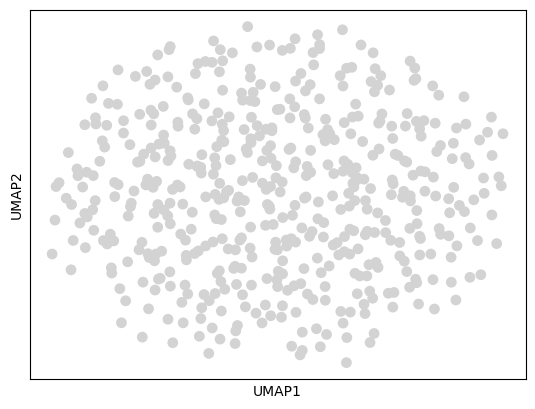

In [21]:
sc.pl.umap(adata_tmp)

In [22]:
data = []

for batch in estimator.datamodule["train_dataloader"]:
    data.append(batch["X"])

In [23]:
d = torch.cat(data)

In [24]:
adata_tmp = sc.AnnData(X=d.cpu().numpy())
sc.tl.pca(adata_tmp)
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)

In [25]:
d.shape

torch.Size([146312, 2000])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


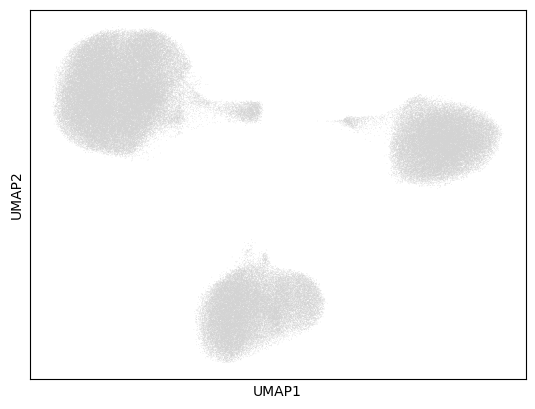

In [26]:
sc.pl.umap(adata_tmp)

**Examine why it does not work**

In [7]:
estimator.generative_model.state_dict()['denoising_model.decoder.0.out_layer.2.weight']

tensor([[-8.0854e-09,  3.6758e-07, -1.5901e-07,  ..., -1.0590e-04,
          9.9414e-28, -1.4854e-12],
        [ 1.2159e-08, -1.5221e-06,  3.3158e-07,  ..., -3.5521e-04,
         -2.9623e-28, -2.9429e-12],
        [ 1.3877e-08,  1.5744e-06,  6.2369e-07,  ..., -2.7559e-05,
          4.0398e-28,  1.7251e-13],
        ...,
        [-5.3922e-09,  1.2626e-06, -2.1996e-07,  ...,  8.8867e-05,
          2.8873e-28, -2.5050e-12],
        [-4.5926e-10, -1.3519e-06, -8.6397e-07,  ...,  1.6750e-04,
         -3.6178e-28,  1.1942e-13],
        [ 5.2262e-09, -7.5689e-07, -1.6243e-09,  ...,  7.4320e-04,
         -3.6120e-28,  1.3108e-13]])

In [12]:
next(iter(estimator.datamodule["train_dataloader"]))

{'X': tensor([[-0.2312, -0.2312,  3.0452,  ..., -0.2312, -0.2312, -0.2312],
         [-0.1532, -0.1532, -0.1532,  ..., -0.1532, -0.1532, -0.1532],
         [ 0.2851, -0.3492,  1.8737,  ..., -0.3492, -0.3492, -0.3492],
         ...,
         [-0.2657, -0.2657,  5.0004,  ..., -0.2657, -0.2657, -0.2657],
         [-0.3009, -0.3009,  1.2374,  ..., -0.3009, -0.3009, -0.3009],
         [-0.2420, -0.2420,  4.5480,  ..., -0.2420, -0.2420, -0.2420]]),
 'X_degs': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'y': {'y_cell_type': tensor([2, 0, 2, 2, 2, 0, 2, 1, 1, 1, 0, 1, 2, 2, 0, 2, 1, 2, 2, 0, 0, 2, 1, 2,
          1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2,
          2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2,
          0, 1,

In [7]:
x = torch.randn(1, 2003)

In [8]:
estimator.generative_model.denoising_model.encoder[0].net(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2003 and 2000x128)